# Extract, Transform, Load

In [29]:
from pystac_client import Client
from odc.stac import load

In [42]:
client = Client.open("https://earth-search.aws.element84.com/v1") # Earth Data From Nasa
collection = "sentinel-2-l2a" # Satelitte 
tas_bbox = [-110, 52, -109.95, 52.05] # Coordinates min lon, min lat, max lo and max lat # 0.1 
search = client.search(collections=[collection], bbox=tas_bbox, datetime="2023-07") # choose a month

data = load(search.items(), bbox=tas_bbox, groupby="solar_day", chunks={})

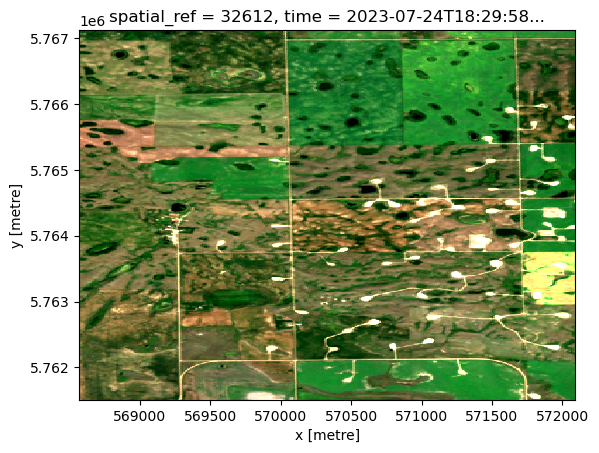

In [43]:
data[["red", "green", "blue"]].isel(time=9).to_array().plot.imshow(robust=True) # printing images in Python

# EDA

In [100]:
import geopandas as gpd
from shapely.geometry import Point

# Define bounding box coordinates
xmin, ymin, xmax, ymax = -110, 52, -109.95, 52.05

# Create 10 points south to east
south_to_east_points = []
for i in range(10):
    x = xmin + (i * (xmax - xmin) / 9)
    for j in range(10):
        y = ymin + (j * (ymax - ymin) / 9)
        point = Point(x, y)
        south_to_east_points.append(point)

# Create 10 points north to south
north_to_south_points = []
for j in range(10):
    y = ymax - (j * (ymax - ymin) / 9)
    for i in range(10):
        x = xmin + (i * (xmax - xmin) / 9)
        point = Point(x, y)
        north_to_south_points.append(point)

# Create GeoDataFrame for the points
south_to_east_gdf = gpd.GeoDataFrame(geometry=south_to_east_points, crs='EPSG:4326')
north_to_south_gdf = gpd.GeoDataFrame(geometry=north_to_south_points, crs='EPSG:4326')

In [101]:
south_to_east_gdf.explore()

In [95]:
south_to_east_gdf.to_file('/Users/ruhidmirzayev/Desktop/test_sat_imag.geojson', driver='GeoJSON')

# Machine Learning Deployment

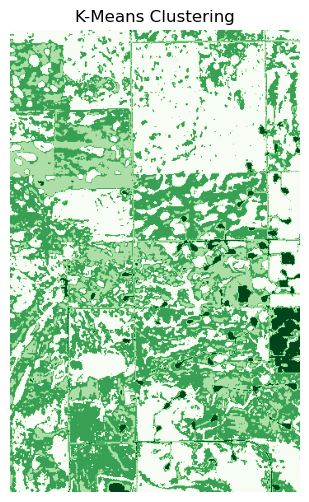

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming data is already loaded and available

# Reshape the image data
image_array = np.stack([data["red"].isel(time=9).values,
                        data["green"].isel(time=9).values,
                        data["blue"].isel(time=9).values], axis=-1)

# Flatten the image array
w, h, d = image_array.shape
image_array_flat = np.reshape(image_array, (w * h, d))

# Perform k-means clustering
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(image_array_flat)

# Predict color indices for each pixel
labels = kmeans.predict(image_array_flat)
codebook_random = kmeans.cluster_centers_

# Reshape the labels to the original image shape
labels = labels.reshape(w, h)

# Plot the clustered image
plt.figure(figsize=(8, 6))
plt.imshow(labels, cmap='Greens')
plt.title('K-Means Clustering')
plt.axis('off')
plt.show()

# Validation

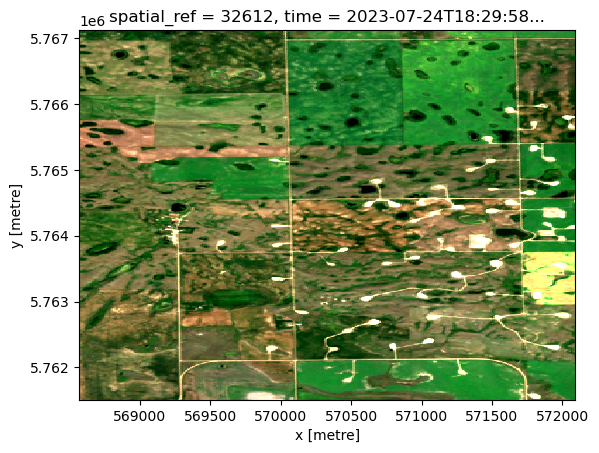

In [78]:
data[["red", "green", "blue"]].isel(time=9).to_array().plot.imshow(robust=True) # printing images in Python

# Joining Geo Data Tables

In [106]:
import geopandas as gpd

In [110]:
import geodatasets

chicago = gpd.read_file(
    geodatasets.get_path("geoda.chicago_health"))

groceries = gpd.read_file(
    geodatasets.get_path("geoda.groceries")
).to_crs(chicago.crs)

In [112]:
chicago.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 87 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ComAreaID   77 non-null     int64   
 1   community   77 non-null     object  
 2   TRACTCnt    77 non-null     int64   
 3   shape_area  77 non-null     float64 
 4   shape_len   77 non-null     float64 
 5   Pop2012     77 non-null     int64   
 6   Pop2014     77 non-null     int64   
 7   PopChng     77 non-null     float64 
 8   PopM        77 non-null     int64   
 9   PopMP       77 non-null     float64 
 10  PopF        77 non-null     int64   
 11  PopFP       77 non-null     float64 
 12  Under5      77 non-null     int64   
 13  Under5P     77 non-null     float64 
 14  Under18     77 non-null     int64   
 15  Under18P    77 non-null     float64 
 16  Over18      77 non-null     int64   
 17  Over18P     77 non-null     float64 
 18  Over21      77 non-null     int64   
 19  Ov

In [114]:
chicago.explore()

In [116]:
groceries.explore()

In [117]:
print(len(chicago))
print(len(groceries))

77
148


In [130]:
chicago.duplicated(subset=['community'])

0     False
1     False
2     False
3     False
4     False
      ...  
72    False
73    False
74    False
75    False
76    False
Length: 77, dtype: bool

## Inner join

In [119]:
gpd.sjoin(chicago, groceries, how='inner', predicate = 'intersects')

,ComAreaID,community,TRACTCnt,shape_area,shape_len,Pop2012,Pop2014,PopChng,PopM,PopMP,...,Tuberc,geometry,index_right,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category
0,35,DOUGLAS,10,4.600462e+07,31027.054510,18238,19430,3.1645,8294,42.6866,...,4.2,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",88,369,41.832885,-87.623453,OPEN,"443 E 34TH ST, CHICAGO, IL. 60616-4135",JEWEL OSCO,None
5,4,LINCOLN SQUARE,11,7.135233e+07,36624.603085,39493,39547,0.0683,19760,49.9659,...,8.5,"POLYGON ((-87.67441 41.97610, -87.67440 41.976...",47,257,41.968830,-87.695252,OPEN,"2632 W LAWRENCE AVE, CHICAGO, IL. 60625-2945",HARVESTIME FOODS,None
7,41,HYDE PARK,12,4.510538e+07,29746.708202,25681,26705,1.9547,12941,48.4591,...,5.3,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",20,124,41.795382,-87.589283,OPEN,"1526 E 55TH ST, CHICAGO, IL. 60615-5527",TREASURE ISLAND FOODS,None
7,41,HYDE PARK,12,4.510538e+07,29746.708202,25681,26705,1.9547,12941,48.4591,...,5.3,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",12,58,41.799463,-87.596114,OPEN,"1226 E 53RD ST, CHICAGO, IL. 60615-4008",HYDE PARK PRODUCE LMT,confirmed
7,41,HYDE PARK,12,4.510538e+07,29746.708202,25681,26705,1.9547,12941,48.4591,...,5.3,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",18,121,41.802441,-87.588208,OPEN,"1521 E HYDE PARK BLVD, CHICAGO, IL. 60615",LEAMINGTON FOODS,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,75,MORGAN PARK,7,9.187734e+07,46396.419362,22530,29300,13.0619,13625,46.5017,...,2.6,"POLYGON ((-87.64215 41.68508, -87.64249 41.685...",1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",139,581,41.976780,-87.654843,NewLocation,"5201 N Sheridan Rd, Chicago, IL 60640",Mariano's,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",104,426,41.979425,-87.659953,OPEN,"5343 N BROADWAY ST, CHICAGO, IL. 60640-2311",JEWEL OSCO,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",107,435,41.982645,-87.668979,OPEN,"5516 N CLARK ST, CHICAGO, IL. 60640-1214",JEWEL OSCO,None


In [125]:
gdf_merged_inner = gpd.sjoin(chicago, groceries, how='inner', predicate = 'intersects')

In [126]:
gdf_merged_inner

,ComAreaID,community,TRACTCnt,shape_area,shape_len,Pop2012,Pop2014,PopChng,PopM,PopMP,...,Tuberc,geometry,index_right,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category
0,35,DOUGLAS,10,4.600462e+07,31027.054510,18238,19430,3.1645,8294,42.6866,...,4.2,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",88,369,41.832885,-87.623453,OPEN,"443 E 34TH ST, CHICAGO, IL. 60616-4135",JEWEL OSCO,None
5,4,LINCOLN SQUARE,11,7.135233e+07,36624.603085,39493,39547,0.0683,19760,49.9659,...,8.5,"POLYGON ((-87.67441 41.97610, -87.67440 41.976...",47,257,41.968830,-87.695252,OPEN,"2632 W LAWRENCE AVE, CHICAGO, IL. 60625-2945",HARVESTIME FOODS,None
7,41,HYDE PARK,12,4.510538e+07,29746.708202,25681,26705,1.9547,12941,48.4591,...,5.3,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",20,124,41.795382,-87.589283,OPEN,"1526 E 55TH ST, CHICAGO, IL. 60615-5527",TREASURE ISLAND FOODS,None
7,41,HYDE PARK,12,4.510538e+07,29746.708202,25681,26705,1.9547,12941,48.4591,...,5.3,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",12,58,41.799463,-87.596114,OPEN,"1226 E 53RD ST, CHICAGO, IL. 60615-4008",HYDE PARK PRODUCE LMT,confirmed
7,41,HYDE PARK,12,4.510538e+07,29746.708202,25681,26705,1.9547,12941,48.4591,...,5.3,"POLYGON ((-87.58038 41.80253, -87.58040 41.802...",18,121,41.802441,-87.588208,OPEN,"1521 E HYDE PARK BLVD, CHICAGO, IL. 60615",LEAMINGTON FOODS,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,75,MORGAN PARK,7,9.187734e+07,46396.419362,22530,29300,13.0619,13625,46.5017,...,2.6,"POLYGON ((-87.64215 41.68508, -87.64249 41.685...",1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",139,581,41.976780,-87.654843,NewLocation,"5201 N Sheridan Rd, Chicago, IL 60640",Mariano's,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",104,426,41.979425,-87.659953,OPEN,"5343 N BROADWAY ST, CHICAGO, IL. 60640-2311",JEWEL OSCO,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",107,435,41.982645,-87.668979,OPEN,"5516 N CLARK ST, CHICAGO, IL. 60640-1214",JEWEL OSCO,None


## Left Join

In [121]:
gpd.sjoin(chicago, groceries, how='left', predicate = 'intersects')

,ComAreaID,community,TRACTCnt,shape_area,shape_len,Pop2012,Pop2014,PopChng,PopM,PopMP,...,Tuberc,geometry,index_right,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category
0,35,DOUGLAS,10,4.600462e+07,31027.054510,18238,19430,3.1645,8294,42.6866,...,4.2,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",88.0,369.0,41.832885,-87.623453,OPEN,"443 E 34TH ST, CHICAGO, IL. 60616-4135",JEWEL OSCO,None
1,36,OAKLAND,3,1.691396e+07,19565.506153,5918,6473,4.4791,2499,38.6065,...,6.7,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,FULLER PARK,2,1.991670e+07,25339.089750,2876,2543,-6.1450,1218,47.8962,...,0.0,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38,GRAND BOULEVARD,14,4.849250e+07,28196.837157,21929,22531,1.3540,9681,42.9675,...,13.2,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39,KENWOOD,7,2.907174e+07,23325.167906,17841,18217,1.0428,8543,46.8958,...,0.0,"POLYGON ((-87.59215 41.81693, -87.59215 41.816...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,76,OHARE,6,3.718356e+08,173625.984660,12559,22239,27.8177,11358,51.0724,...,6.3,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",139.0,581.0,41.976780,-87.654843,NewLocation,"5201 N Sheridan Rd, Chicago, IL 60640",Mariano's,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",104.0,426.0,41.979425,-87.659953,OPEN,"5343 N BROADWAY ST, CHICAGO, IL. 60640-2311",JEWEL OSCO,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",107.0,435.0,41.982645,-87.668979,OPEN,"5516 N CLARK ST, CHICAGO, IL. 60640-1214",JEWEL OSCO,None


In [123]:
gdf_merged_left = gpd.sjoin(chicago, groceries, how='left', predicate = 'intersects')

In [124]:
gdf_merged_left

,ComAreaID,community,TRACTCnt,shape_area,shape_len,Pop2012,Pop2014,PopChng,PopM,PopMP,...,Tuberc,geometry,index_right,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category
0,35,DOUGLAS,10,4.600462e+07,31027.054510,18238,19430,3.1645,8294,42.6866,...,4.2,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",88.0,369.0,41.832885,-87.623453,OPEN,"443 E 34TH ST, CHICAGO, IL. 60616-4135",JEWEL OSCO,None
1,36,OAKLAND,3,1.691396e+07,19565.506153,5918,6473,4.4791,2499,38.6065,...,6.7,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,FULLER PARK,2,1.991670e+07,25339.089750,2876,2543,-6.1450,1218,47.8962,...,0.0,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38,GRAND BOULEVARD,14,4.849250e+07,28196.837157,21929,22531,1.3540,9681,42.9675,...,13.2,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39,KENWOOD,7,2.907174e+07,23325.167906,17841,18217,1.0428,8543,46.8958,...,0.0,"POLYGON ((-87.59215 41.81693, -87.59215 41.816...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,76,OHARE,6,3.718356e+08,173625.984660,12559,22239,27.8177,11358,51.0724,...,6.3,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",139.0,581.0,41.976780,-87.654843,NewLocation,"5201 N Sheridan Rd, Chicago, IL 60640",Mariano's,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",104.0,426.0,41.979425,-87.659953,OPEN,"5343 N BROADWAY ST, CHICAGO, IL. 60640-2311",JEWEL OSCO,None
75,77,EDGEWATER,17,4.844999e+07,31004.830946,54891,55276,0.3495,27729,50.1646,...,10.5,"POLYGON ((-87.65456 41.99817, -87.65456 41.998...",107.0,435.0,41.982645,-87.668979,OPEN,"5516 N CLARK ST, CHICAGO, IL. 60640-1214",JEWEL OSCO,None


## Right Join

In [122]:
gpd.sjoin(chicago, groceries, how='right', predicate = 'intersects')

,index_left,ComAreaID,community,TRACTCnt,shape_area,shape_len,Pop2012,Pop2014,PopChng,PopM,...,GonorrM,Tuberc,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,30,3,UPTOWN,12,6.509564e+07,46972.794555,56362,54062,-2.0829,28072,...,468.7,13.6,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,None,MULTIPOINT ((-87.65661 41.97321))
1,73,75,MORGAN PARK,7,9.187734e+07,46396.419362,22530,29300,13.0619,13625,...,741.1,2.6,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None,MULTIPOINT ((-87.68136 41.69713))
2,28,28,NEAR WEST SIDE,20,1.584925e+08,53003.592941,54881,58899,3.5314,29276,...,466.5,14.1,22,41.868634,-87.638638,OPEN,"1101 S CANAL ST, CHICAGO, IL. 60607-4932",WHOLE FOODS MARKET,None,MULTIPOINT ((-87.63918 41.86847))
3,28,28,NEAR WEST SIDE,20,1.584925e+08,53003.592941,54881,58899,3.5314,29276,...,466.5,14.1,23,41.877590,-87.654953,OPEN,"1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905",TARGET/SUPER,new,MULTIPOINT ((-87.65495 41.87783))
4,39,44,CHATHAM,10,8.232067e+07,42006.945009,31028,31493,0.7438,13676,...,1855.8,8.2,27,41.737696,-87.625795,OPEN,"112 W 87TH ST, CHICAGO, IL. 60620-1318",FOOD 4 LESS,None,MULTIPOINT ((-87.62715 41.73623))
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,28,28,NEAR WEST SIDE,20,1.584925e+08,53003.592941,54881,58899,3.5314,29276,...,466.5,14.1,585,41.880834,-87.647729,Chicago-West Loop,"40 S Halsted St, Chicago, IL 60661",Mariano's,None,MULTIPOINT ((-87.64732 41.88063))
144,22,22,LOGAN SQUARE,27,1.000576e+08,49213.421749,73595,74055,0.3115,37560,...,159.3,8.4,586,41.920842,-87.669112,NewLocation,"2112 N Ashland Ave, Chicago IL 60614",Mariano's,None,MULTIPOINT ((-87.66839 41.92006))
145,55,59,MCKINLEY PARK,5,3.943180e+07,26014.096837,15612,16449,2.6106,8408,...,0.0,11.5,587,41.835930,-87.664034,Chicago-Bridgeport,"3145 S Ashland Ave, Chicago, IL 60608",Mariano's,None,MULTIPOINT ((-87.66570 41.83613))
146,33,33,NEAR SOUTH SIDE,3,4.976964e+07,45053.165104,21390,22021,1.4535,10755,...,318.7,5.0,588,41.859370,-87.630062,Chicago-South Loop,"1615 S Clark St, Chicago, IL 60616",Mariano's,None,MULTIPOINT ((-87.63024 41.85961))
